In [1]:
save_damped_proportion_pdf = TRUE

In [2]:
source("tools.R")

Warning message:
"package 'plyr' was built under R version 3.3.3"Warning message:
"package 'tidyverse' was built under R version 3.3.3"Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'tibble' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"Warning message:
"package 'readr' was built under R version 3.3.3"Warning message:
"package 'purrr' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summa

In [3]:
library(gridExtra)

Warning message:
"package 'gridExtra' was built under R version 3.3.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [4]:
# Kernel composition name change
#l+r+p -> l+p+r
#l+r*p -> l+p*r
#l*r*p -> l*p*r

readable_kernel <- function(current_kernel){
    new_kernel <- current_kernel
    
    new_kernel <- ifelse(new_kernel == 'l+r+p', 'l+p+r', new_kernel)
    new_kernel <- ifelse(new_kernel == 'l+r*p', 'l+p*r', new_kernel)
    new_kernel <- ifelse(new_kernel == 'l*r*p', 'l*p*r', new_kernel)
    
    new_kernel <- gsub("\\*", "×", new_kernel)
    
    return(new_kernel)
}

# Get the range of a scenario
get_range <- function(scenario_name) {
    switch( scenario_name,
            'Temperature' = c(-10, 40),
            'Rain' = c(0, 100),
            'Sales' = c(0, 5000),
            'Gym members' = c(0, 50),
            'Salary' = c(0, 50),
            'FB Friends' = c(0, 1000))
}

kernels  <- c("l", "p", "r", "l+p", "l+r", "p+r", "l*r", "l*p", "p*r", "l+r+p", "l+r*p", "l*r+p", "l*p+r", "l*r*p")

# Plotting functions

In [5]:
plot_lmls <- function(prop_data, title='', scenario, hide_x=FALSE, hide_y=FALSE, red_border=TRUE) {
    
    # Best-fitting real-world data kernel composition
    rw_lmls <- read_csv("data/real-world/to-plot.csv")
    red_kernel <- (rw_lmls %>%
                    filter(scenario == !!scenario) %>%
                    summarize(red_kernel = kernel[which.max(lml)]))$red_kernel
    red_kernel <- readable_kernel(red_kernel)

    plot <- prop_data %>%
                ggplot(aes(x=kernel, y=value)) +
                    geom_bar(stat='identity') +
                    geom_bar(stat='identity', data=prop_data %>% filter(kernel == red_kernel), alpha=0, size=0.5, color="red") +
                    coord_cartesian (ylim=c(0, 1)) +
                    #labs(title = title) +
                    ggthemes::theme_few() +
                    xlab("Kernel composition") +
                    ylab("Likelihood") +
                    geom_errorbar(aes(ymin=as.numeric(lo_ci), ymax=as.numeric(hi_ci)),
                                      width=.3,
                                      position=position_dodge(.9)) +
                    scale_y_continuous(breaks = seq(0, 1, length.out=3)) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          text = element_text(size=12, family="serif"))

    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}

In [6]:
plot_curves <- function(plot_data, plot_rwdata, ylab='', scenario, hide_x=FALSE, hide_y=FALSE) {

    # Min and max value of the data to be shown
    range_y <- get_range(scenario)
    limits_y <- c( min(range_y[1], min(plot_data$value)), max(range_y[2], max(plot_data$value)))
    
    # Mean trend
    trend <- plot_data %>% group_by(day) %>% summarize(mean_y = mean(value))
    
    # Plotting
    plot <- plot_data %>%
                ggplot(aes(x=day, y=value, group=id)) +
                    geom_line(col="steelblue", alpha=0.2) + # Participants' curves
                    geom_line(data=plot_rwdata, aes(x=day, group=1), colour="red", alpha=0.6) + # Real world data
                    geom_line(data=trend, aes(x=day, y=mean_y, group=1), colour="black") + # Mean trend
                    #labs(title = title) +
                    ggthemes::theme_few() +
                    ylab(ylab) +
                    scale_x_continuous(breaks = c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
                    scale_y_continuous(breaks = seq(range_y[1], range_y[2], length.out=3), limits=limits_y) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          axis.text.y = element_text(angle = 90,  vjust = 0.5, hjust=0.5),
                          text = element_text(size=12, family="serif"))

    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}

# Prior: Kernel compositions bar plots

##### Import and prepare the data

In [50]:
data_prior <- read_csv("data/for_composititional_analysis_prior.csv")

# Get a "dictionary" of ID, PID, Scenario
dict_prior <- data_prior %>%                        
                        group_by(id, pid, scenario) %>%
                        summarize()

# Get the results of the LML analysis over the prior data
prior_results <- read_csv('output/minus-mean-treatment/results_prior_lmls.csv')

# Merge the results with the dictionary to have a 'full view' of the situation
lmls_prior <- merge(prior_results, dict_prior, by.x='cid', by.y='id', all.x=TRUE)

# Kernel composition name change
lmls_prior$kernel <- readable_kernel(lmls_prior$kernel)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double()
)
Parsed with column specification:
cols(
  cid = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)


In [10]:
# Removes the GPs that failed to be optimized in the second time. The lmls that failed to be optimized are also removed.
#Finaly, the lml_standard is calculated
lmls_prior_f <- lmls_prior %>%
                    filter(second_exception == 'False' & lml != -999999999) %>%
                    group_by(pid, scenario) %>%
                    mutate(lml_minus_min = lml - min(lml),
                           lml_standard = lml_minus_min / (max(lml_minus_min) - min (lml_minus_min)))

sds <- lmls_prior_f %>% 
            group_by(kernel, scenario) %>%
            summarize(lo_bound = mean(lml) - 5*sd(lml), up_bound = mean(lml) + 5*sd(lml))

sds$ks <- paste0(sds$kernel, sds$scenario)

lmls_prior_f$ks <- paste0(lmls_prior_f$kernel, lmls_prior_f$scenario)

sds$kernel <- NULL
sds$scenario <- NULL

lmls_prior_f <- merge(x = lmls_prior_f, y = sds, by = "ks", all.x = TRUE)

##### Prepare the plots

In [11]:
normalize_bool = TRUE
plot_bool      = TRUE

lmls_prior_ff <- lmls_prior_f %>% 
            filter(lml > -10000) %>%
            filter(lml > lo_bound & lml < up_bound)

to_plot_prior <- lmls_prior_ff %>%
            group_by(kernel, scenario) %>%
            summarize(value = mean(lml),
                      lo_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['lwr.ci'],
                      hi_ci = MeanCI(lml, method="boot", type="norm", na.rm=TRUE)['upr.ci'])

# Remove single components
to_plot_prior <- to_plot_prior %>%
                filter(kernel != 'l', kernel != 'p', kernel != 'r')

# Scaling the 'data to plot' to a 0-1 range
min_v = min(to_plot_prior$value)
range_v = max(to_plot_prior$value) - min(to_plot_prior$value)

if(normalize_bool) {
    #Normalization
    to_plot_prior <- to_plot_prior %>%
                    group_by( scenario ) %>%
                    mutate( lo_ci = (lo_ci - min(value)) / (max(value) - min(value)),
                            hi_ci = (hi_ci - min(value)) / (max(value) - min(value)),  
                            value = (value - min(value)) / (max(value) - min(value)))
}

# Plotting magic
to_plot_prior$kernel <- factor(to_plot_prior$kernel, levels=readable_kernel(kernels))

lmls_temperature <- to_plot_prior %>% filter(scenario == "Temperature")
lmls_rain <- to_plot_prior %>% filter(scenario == "Rain")
lmls_sales <- to_plot_prior %>% filter(scenario == "Sales")
lmls_gym <- to_plot_prior %>% filter(scenario == "Gym members")
lmls_salary <- to_plot_prior %>% filter(scenario == "Salary")
lmls_fb <- to_plot_prior %>% filter(scenario == "FB Friends")


if (plot_bool) {
    # Plots
    p_temp   <- plot_lmls( lmls_temperature, scenario="Temperature", hide_x=TRUE, hide_y=FALSE)
    p_rain   <- plot_lmls( lmls_rain,        scenario="Rain",        hide_x=TRUE, hide_y=FALSE)
    p_sales  <- plot_lmls( lmls_sales,       scenario="Sales",       hide_x=TRUE, hide_y=FALSE)
    p_gym    <- plot_lmls( lmls_gym,         scenario="Gym members", hide_x=TRUE, hide_y=FALSE)
    p_salary <- plot_lmls( lmls_salary,      scenario="Salary",      hide_x=TRUE, hide_y=FALSE)
    p_fb     <- plot_lmls( lmls_fb,          scenario="FB Friends",  hide_x=TRUE, hide_y=FALSE)

    #pdf("Images/paper_images/kernels_priors_lmls_5sd.pdf", width=8, height=4)
    #multiplot(p1, p2, p3, p4, p5, p6, cols=3)
    #dev.off()   
}

Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)
Parsed with column specification:
cols(
  scenario = col_character(),
  kernel = col_character(),
  lml = col_double()
)


# Prior: Curves (participant's data)

##### Plotting

In [12]:
mean_centering <- function(rwdata, dat, scenario) {
    mean_rw <- rwdata %>% filter(scenario == !!scenario) %>% summarize(mv=mean(value))
    
    mean_dat <- dat %>% filter(scenario == !!scenario, condition == 'Prior') %>% summarize(mv=mean(value))    
    
    mean_dat$mv / mean_rw$mv
}

# Real-world data
rwdata <- read_csv('data/real-world/splines.csv')

rwdata$condition <- 'Prior' # Add column
rwdata$id <- 1 #Create a new ID column
rwdata <- filter(rwdata, day >= 31) # Filter out the initial days
rwdata <- filter(rwdata, day <= 365*4 - 31) # Filter out the final days

# Order
rwdata$condition <- factor( rwdata$condition, levels = condition_names)
rwdata$scenario <- factor( rwdata$scenario, levels = readable_scenarios)

# Scale the values
rwdata[rwdata$scenario == 'Rain', 'day'] <- rwdata[rwdata$scenario == 'Rain', 'day'] + (365/12) * 1.5 #Offset 1.5 months to the right

# Mean centering
for (s in readable_scenarios){
    rwdata[rwdata$scenario == s, 'value'] <- rwdata[rwdata$scenario == s, 'value'] * mean_centering(rwdata, dat, s)
}

Parsed with column specification:
cols(
  scenario = col_character(),
  day = col_integer(),
  value = col_double()
)


In [13]:
curves_plot <- function(scenario_name, ...) {
    dat %>% 
        filter(scenario==scenario_name, condition=='Prior') %>% 
        plot_curves(rwdata %>% filter(scenario==scenario_name), scenario=scenario_name, ylab=scenario_name, ...)
}

In [14]:
p_temp_curves   <- curves_plot('Temperature', hide_x=TRUE, hide_y=FALSE)
p_rain_curves   <- curves_plot('Rain',        hide_x=TRUE, hide_y=FALSE)
p_sales_curves  <- curves_plot('Sales',       hide_x=TRUE, hide_y=FALSE)
p_gym_curves    <- curves_plot('Gym members', hide_x=TRUE, hide_y=FALSE)
p_salary_curves <- curves_plot('Salary',      hide_x=TRUE, hide_y=FALSE)
p_fb_curves     <- curves_plot('FB Friends',  hide_x=TRUE, hide_y=FALSE)

In [15]:
if(FALSE){
    # Save/show
    pdf("Images/paper_images/grid_plot_prior.pdf", width=6, height=10)
    grid.arrange(p_temp_curves,   p_temp, 
                 p_rain_curves,   p_rain, 
                 p_sales_curves,  p_sales, 
                 p_gym_curves,    p_gym, 
                 p_salary_curves, p_salary, 
                 p_fb_curves,     p_fb, 
                 ncol=2)
    dev.off()   
}

# Posterior: Curves (participants' data)

In [16]:
plot_curves_posterior <- function(plot_data, ylab='', scenario, hide_x=FALSE, hide_y=FALSE) {

    # Min and max value of the data to be shown
    range_y <- get_range(scenario)
    limits_y <- c( min(range_y[1], min(plot_data$value)), max(range_y[2], max(plot_data$value)))
    
    # Mean trend
    trend_1 <- plot_data %>% filter(condition=='Posterior-Positive') %>% group_by(day) %>% summarize(mean_y = mean(value))
    trend_2 <- plot_data %>% filter(condition=='Posterior-Stable') %>%   group_by(day) %>% summarize(mean_y = mean(value))
    trend_3 <- plot_data %>% filter(condition=='Posterior-Negative') %>% group_by(day) %>% summarize(mean_y = mean(value))
    
    # Plotting
    plot <- plot_data %>%
                ggplot(aes(x=day, y=value, group=id)) +
                    # Curves:
                    geom_line(data=plot_data %>% filter(condition=='Posterior-Positive'), col="steelblue", alpha=0.1) +
                    geom_line(data=plot_data %>% filter(condition=='Posterior-Stable'),   col="firebrick", alpha=0.1) +
                    geom_line(data=plot_data %>% filter(condition=='Posterior-Negative'), col="olivedrab", alpha=0.1) +
                    
                    # Mean curves
                    geom_line(data=trend_1, aes(x=day, y=mean_y, group=1), colour="blue") +
                    geom_line(data=trend_2, aes(x=day, y=mean_y, group=1), colour="red") +
                    geom_line(data=trend_3, aes(x=day, y=mean_y, group=1), colour="darkgreen") +
                    
                    # Vertical line (end of evidence mark)
                    geom_vline(aes(xintercept=365-31), colour='black') +
    
                    ggthemes::theme_few() +
                    ylab(ylab) +
                    scale_x_continuous(breaks = c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
                    scale_y_continuous(breaks = seq(range_y[1], range_y[2], length.out=3), limits=limits_y) +
                    theme(axis.text.x = element_text(angle = 90,  vjust = 0.5, hjust=0),
                          axis.text.y = element_text(angle = 90,  vjust = 0.5, hjust=0.5),
                          text = element_text(size=12, family="serif"))

    if(hide_x){
        plot <- plot + theme(axis.title.x=element_blank())
    }
    if(hide_y){
        plot <- plot + theme(axis.title.y=element_blank())
    }
    
    return(plot)
}
    
curves_plot_posterior <- function(scenario_name, ...) {
    dat %>% 
        filter(scenario==scenario_name, condition!='Prior') %>% 
        plot_curves_posterior(scenario=scenario_name, ylab=scenario_name, ...)
}

In [17]:
posterior_curves_temp <- curves_plot_posterior('Temperature', hide_x=TRUE, hide_y=FALSE)
posterior_curves_rain <- curves_plot_posterior('Rain',        hide_x=TRUE, hide_y=FALSE)
posterior_curves_sale <- curves_plot_posterior('Sales',       hide_x=TRUE, hide_y=FALSE)
posterior_curves_gymm <- curves_plot_posterior('Gym members', hide_x=TRUE, hide_y=FALSE)
posterior_curves_slry <- curves_plot_posterior('Salary',      hide_x=TRUE, hide_y=FALSE)
posterior_curves_fbfr <- curves_plot_posterior('FB Friends',  hide_x=TRUE, hide_y=FALSE)

# Posterior: Performance. Prediction against participant's results

##### Importing the posterior kernel composition data

In [18]:
lmls_posterior <- read_csv("output/minus-mean-treatment/results_posterior_lmls.csv")

# To add the 'scenario' column
data_posterior <- read_csv("data/for_composititional_analysis_posterior.csv")


# Posterior "dictionary"
dict_posterior <- data_posterior %>%                        
                        group_by(id, pid, scenario) %>%
                        summarize()

lmls_posterior <- merge(x = lmls_posterior, y = dict_posterior, by = c("id", "id"), all.x = TRUE)

# Removing unusable data, and standardizing.
lmls_posterior_f <- lmls_posterior %>%
                    filter(second_exception == 'False' & lml != -999999999) %>%
                    group_by(pid, scenario) %>%
                    mutate(lml_minus_min = lml - min(lml),
                           lml_standard = lml_minus_min / (max(lml_minus_min) - min (lml_minus_min)))

# Standard deviations calculation
sds <- lmls_posterior_f %>% 
            group_by(kernel, scenario) %>%
            summarize(lo_bound = mean(lml) - 5*sd(lml), up_bound = mean(lml) + 5*sd(lml))

sds$ks <- paste0(sds$kernel, sds$scenario)

lmls_posterior_f$ks <- paste0(lmls_posterior_f$kernel, lmls_posterior_f$scenario)

sds$kernel <- NULL
sds$scenario <- NULL

lmls_posterior_f <- merge(x = lmls_posterior_f, y = sds, by = "ks", all.x = TRUE)

lmls_posterior_ff <- lmls_posterior_f %>%
            filter(lml > -10000) %>%
            filter(lml > lo_bound & lml < up_bound)

Parsed with column specification:
cols(
  id = col_integer(),
  kernel = col_character(),
  lml = col_double(),
  white_added = col_character(),
  second_exception = col_character()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  id = col_integer(),
  pid = col_character(),
  scenario = col_character(),
  x = col_integer(),
  y = col_double(),
  condition = col_character()
)


###### Importing the predictions

In [19]:
# Import the predictions
predictions_csv <- read_csv('output/minus-mean-treatment/results_posterior_predictions.csv')

predictions <- predictions_csv %>%
                    mutate(value = as.numeric(substring(predictions_mean, 2, nchar(predictions_mean)-1))) %>%
                    select(cid = pid, kernel = composition, day = Xpredictions, value)

Parsed with column specification:
cols(
  pid = col_integer(),
  composition = col_character(),
  Xpredictions = col_double(),
  predictions_mean = col_character(),
  predictions_var = col_character()
)


In [20]:
# Add the subtracted mean of the 'evidence' data
posterior_means <- data_posterior %>%
                        filter(x <= 365-31) %>%
                        group_by(id) %>%
                        summarize(mean_cid = mean(y))

predictions <- merge(x=predictions, y=posterior_means, by.x='cid', by.y='id', all.x=TRUE)

predictions <- predictions %>% 
                    mutate(value = value + mean_cid) %>%
                    select(-mean_cid)

In [21]:
predictions %>% select(cid) %>% unique %>% nrow

[1] 714

##### Merging and filtering the datasets

In [22]:
# Sequence of days to analyze:
sequence = seq(365-31 + 2, 1426, 5)

In [23]:
# Inner join. 
# This is the predictions data merged with the best performing (and filtered) kernels in the posterior condition
pred <- merge( 
            # Predictions (full-Bayesian):
            x = predictions %>%
                    filter(day %in% sequence),

            # Kernels after the filters:
            y = lmls_posterior_ff %>%
                    select(cid=id, pid, scenario, kernel, lml),

            by = c('cid', 'kernel')
)

In [24]:
# Participants' data
participants_data <- dat %>% 
                        filter(day > 365-31, #remove evidence
                               condition != 'Prior', #only Posterior conditions
                               day %in% sequence) %>%
                        select(pid = id, day, value_participant=value, scenario, condition, noise)

In [26]:
# Merge the predictions with the real participants' data
all_pred_data <- merge(
                # Predictions + Kernel posterior analysis:
                x = pred,
    
                # Participant's data:
                y = participants_data,
    
                by = c('pid', 'scenario', 'day')
)

In [27]:
all_pred_data %>% select(cid) %>% unique %>% nrow

[1] 714

###### Calculating the deviation

In [28]:
#Normalized root mean squared deviation
calculate_nrmsd <- function(value_prediction, value_participant) {
    return (sqrt(sum((value_prediction - value_participant)^2) / length(value_prediction)) / (max(value_participant) - min(value_participant)))
}

#Normalized root mean squared error (as per Mozer et al. (2008))
calculate_nrmse <- function(value_model, value_human) {
    return ( sqrt( sum((value_human - value_model)^2) / sum((value_human - mean(value_human))^2) ) )
}

In [29]:
calculate_nrmse(c(1,2,3,4), c(5,2,3,4))

[1] 1.788854

In [45]:
results_pred <- all_pred_data %>% 
                    #filter(day <= 365*2) %>% # To Eric: this is something I though about. What do you think about it?
                    group_by(pid, scenario, kernel, lml) %>%
                    summarize(error = calculate_nrmse(value, value_participant))

results_pred <- merge(x = results_pred,

                      # Mark the best-fitting kernel in each case
                      y = results_pred %>%
                            filter(nchar(kernel)!= 1) %>%
                            group_by(pid, scenario) %>%
                            mutate(is_max = lml == max(lml)) %>%
                            filter(is_max) %>%
                            select(pid, scenario, kernel, is_max),

                      all.x = TRUE,
                )

results_pred$is_max <- !(is.na(results_pred$is_max))

##### Plotting the deviation

In [46]:
# Filtering in only Linear, RBF, and Best fitting compositions.
to_plot_results_pred <- results_pred %>%
                            filter(kernel == 'l' | kernel == 'r' | is_max)

to_plot_results_pred$readable_kernel <- ifelse(to_plot_results_pred$is_max, 'best', to_plot_results_pred$kernel)

In [47]:
plot_deviation <- function(to_plot_data, ylim) {
    to_plot_data %>%
        ggplot(aes(x=readable_kernel, y=error, group=readable_kernel)) +
                        geom_boxplot(outlier.shape = 1,
                                     outlier.size = 0.5) +
                        
                        scale_x_discrete(breaks = c('best', 'l', 'r'),
                                         labels = c('Compositional', 'Linear', 'RBF')) +

                        ylab("Error") +
                        
                        scale_y_continuous(limits=ylim, breaks = seq(ylim[1], ylim[2], length.out=3)) +

                        ggthemes::theme_few() +
                        theme(text = element_text(size=12, family="serif"),
                                     plot.title = element_text(hjust = 0.5),
                                     legend.position = "none",
                                     axis.title.x = element_blank())
}

In [48]:
posterior_deviation_temp = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Temperature'), ylim = c(0, 10))
posterior_deviation_rain = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Rain'),        ylim = c(0, 10))
posterior_deviation_sale = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Sales'),       ylim = c(0, 10))
posterior_deviation_gymm = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Gym members'), ylim = c(0, 10))
posterior_deviation_slry = plot_deviation( to_plot_results_pred %>% filter(scenario == 'Salary'),      ylim = c(0, 10))
posterior_deviation_fbfr = plot_deviation( to_plot_results_pred %>% filter(scenario == 'FB Friends'),  ylim = c(0, 10))

##### Second grid plot

In [49]:
if(TRUE){
    pdf("Images/paper_images/grid_plot_posterior.pdf", width=6, height=10)
    multiplot(  posterior_curves_temp,
                posterior_curves_rain,
                posterior_curves_sale,
                posterior_curves_gymm,
                posterior_curves_slry,
                posterior_curves_fbfr,
              
                posterior_deviation_temp,
                posterior_deviation_rain,
                posterior_deviation_sale,
                posterior_deviation_gymm,
                posterior_deviation_slry,
                posterior_deviation_fbfr,
                
                cols = 2)
    dev.off()   
}

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 5 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 11 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 13 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 9 rows containing non-finite values (stat_boxplot)."

png 
  2

# Trend damping
### Goal: Proportion of damped predictions. Participants vs GP Predictions.

###### Calculate underlying trend

In [312]:
df <- dat %>%
        group_by(condition, scenario, day) %>%
        summarize

df$slope_scale <- mapvalues(df$condition,
                              from = c("Prior", "Posterior-Positive", "Posterior-Stable", "Posterior-Negative"),
                              to   = c(0, 1, 0, -1))

df$range <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 40--10,        100-0,  5000-0,  50-0,          50-0,     1000-0))

df$y_intercept <- mapvalues(df$scenario,
                              from = c("Temperature", "Rain", "Sales", "Gym members", "Salary", "FB Friends"),
                              to   = c( 15,            30,     2500,    25,            20,       500))


# Transformations to numbers
df$slope_scale <- as.numeric(levels(df$slope_scale))[df$slope_scale]
df$range <- as.numeric(levels(df$range))[df$range]
df$y_intercept <- as.numeric(levels(df$y_intercept))[df$y_intercept]

# Calculations
df$last_point <- df$y_intercept + 0.05 * df$range * df$slope_scale * 4 

df$slope <- (df$last_point - df$y_intercept) / ((365-31)-1)

df$underlying_trend <- ((df$day-1) * df$slope + df$y_intercept)

# Subtract the mean of each underlying trend
#df <- df %>% 
#        group_by(condition, scenario) %>%
#        mutate(underlying_trend = underlying_trend - mean(underlying_trend))

In [313]:
# Watching the columns
all_pred_data %>% head(3)
df %>% head(3)

all_pred_data %>% nrow
df %>% nrow

pid,scenario,day,cid,kernel,value,lml,value_participant,condition,noise
a001,FB Friends,1001,6,p*r,382.4196,-323.93799,255.7962,Posterior-Negative,3
a001,FB Friends,1001,6,r,382.4216,-22.05855,255.7962,Posterior-Negative,3
a001,FB Friends,1001,6,l*p,382.4216,-87.34479,255.7962,Posterior-Negative,3


condition,scenario,day,slope_scale,range,y_intercept,last_point,slope,underlying_trend
Prior,Temperature,31,0,50,15,15,0,15
Prior,Temperature,32,0,50,15,15,0,15
Prior,Temperature,33,0,50,15,15,0,15


[1] 2126490

[1] 33576

In [314]:
# Merging the data with the underlying trend
data_with_trend <- merge( 
    x = all_pred_data,

    y = df %>% select(condition, scenario, day, underlying_trend),

    by = c('condition', 'scenario', 'day')
)

data_with_trend <- cbind(row_id = rownames(data_with_trend), data_with_trend)

data_with_trend <- merge(   # Original dataset
                            x = data_with_trend,

                            # Mark the best-fitting kernel in each case
                            y = data_with_trend %>%
                                    filter(nchar(kernel)!= 1) %>%
                                    group_by(pid, scenario) %>%
                                    mutate(is_max = lml == max(lml)) %>%
                                    ungroup %>%
                                    filter(is_max) %>%
                                    select(row_id, is_max),

                            by = 'row_id',
                            all.x = TRUE
                )

data_with_trend$is_max <- !(is.na(data_with_trend$is_max))

In [315]:
# Filter out the unnecessary conditions
data_with_trend <- data_with_trend %>%
                                filter(condition == 'Posterior-Positive' |
                                       condition == 'Posterior-Negative')

# Filter out the other scenarios. Leave only Sales.
data_with_trend <- data_with_trend %>%
                                filter(scenario == 'Sales')

# Only have the best-fitting kernel
data_with_trend <- data_with_trend %>%
                                filter(is_max)

In [316]:
# Should be zero because every curve and day combination should only have 1 datapoint
print('should be zero:')

data_with_trend %>% 
    group_by(cid, day) %>%
    filter(length(day) != 1) %>% nrow

data_with_trend %>% 
    group_by(cid, day, kernel) %>%
    filter(length(kernel) != 1) %>% nrow

[1] "should be zero:"


[1] 0

[1] 0

In [317]:
# Which values are "damped"?
add_damped_column <- function(dataset, condition, column_name, new_column_name) {
    
    if(condition == 'Posterior-Negative') {
        damped_column <- dataset[dataset$condition==condition, column_name] > dataset[dataset$condition==condition, 'underlying_trend'] 
    }else if(condition == 'Posterior-Positive') {
        damped_column <- dataset[dataset$condition==condition, column_name] < dataset[dataset$condition==condition, 'underlying_trend'] 
    }
    
    dataset[dataset$condition == condition, new_column_name] <- damped_column
    
    return(dataset)
}
 
# Calculate the 'damped' boolean
data_with_trend <- add_damped_column(data_with_trend, 'Posterior-Negative', 'value_participant', new_column_name='damped_participant')
data_with_trend <- add_damped_column(data_with_trend, 'Posterior-Positive', 'value_participant', new_column_name='damped_participant')
    
data_with_trend <- add_damped_column(data_with_trend, 'Posterior-Negative', 'value', new_column_name='damped_gp')
data_with_trend <- add_damped_column(data_with_trend, 'Posterior-Positive', 'value', new_column_name='damped_gp')

##### Bootstrapped confidence interval (for binomial distribution).

NOTE: Do you like this method Eric? Or should we use a package [like this one](http://math.furman.edu/~dcs/courses/math47/R/library/Hmisc/html/binconf.html)?

In [318]:
bp = function(x, lev, n = 1e3, alpha=0.05) {
  res = replicate(n, sum(sample(x, length(x), replace=TRUE) == lev)/length(x))
  return(list(mean=mean(res),
              `95% CI`=quantile(res, c(0.5*alpha,1-0.5*alpha))))
}

bp2 = function(vector) {
    
    match_ci <- bp(vector, TRUE)
    
    return( c( match_ci$mean %>% round(2),
             match_ci$`95% CI`[1] %>% round(2),
             match_ci$`95% CI`[2] %>% round(2) ))
}

##### Calculate the damped proportion, per condition~day

In [319]:
damped_proportion_participants <- data_with_trend %>%
                                        group_by(condition, day) %>%
                                        summarize(damped_proportion = bp2(damped_participant)[[1]],
                                                  lo_ci = bp2(damped_participant)[[2]],
                                                  hi_ci = bp2(damped_participant)[[3]])

damped_proportion_gps <- data_with_trend %>%
                                        group_by(condition, day) %>%
                                        summarize(damped_proportion = bp2(damped_gp)[[1]],
                                                  lo_ci = bp2(damped_gp)[[2]],
                                                  hi_ci = bp2(damped_gp)[[3]])

In [320]:
plot_with_ribbon <- function(dplot, type=1, title="", xlab="Year", ylab="", hide_legend=FALSE, group="condition", legend_title="Condition") {
    
    if(type == 1){
        y = "damped_proportion"
        ylab = "Proportion of\ndamped predictions"
    }
    
    p <- ggplot(data=dplot, aes_string(x="day", y=y, group=group, colour=group)) +
            geom_line(size=1) +
            geom_ribbon(aes(ymin=lo_ci, ymax=hi_ci), alpha=0.2) +
            #scale_x_continuous(limits +
            #coord_cartesian(ylim = c(0.65, 1.00), xlim = c(365-31, 365*2-10)) +
            labs(colour = legend_title) +
            xlab(xlab) + ylab(ylab) + ggtitle(title) +
            scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
            theme_bw() + 
            ggthemes::theme_few() + 
            theme(text = element_text(size=12, family="serif")) +
            #theme(legend.position=c(0.82, 0.40)) +
            theme(plot.title = element_text(hjust = 0.5)) +
            ggthemes::scale_color_solarized()
        
    if(hide_legend) {
        p <- p + theme(legend.position="none")
    }
    
    return(p)
}

In [321]:
p1 <- plot_with_ribbon(damped_proportion_participants)
p2 <- plot_with_ribbon(damped_proportion_gps)

if(save_damped_proportion_pdf){ #save_damped_proportion_pdf
    pdf("Images/paper_images/damped_proportion.pdf", width=6, height=4)
    multiplot(p1, p2, cols=1)
    dev.off()  
}

png 
  2

In [322]:
pos_trend <- data_with_trend %>% 
                filter(condition == 'Posterior-Positive') %>%
                select(day, underlying_trend) %>%
                arrange(day) %>%
                unique

neg_trend <- data_with_trend %>% 
                filter(condition == 'Posterior-Negative') %>%
                select(day, underlying_trend) %>%
                arrange(day) %>%
                unique

In [323]:
pdf("Images/paper_images/gp_prediction_raw_data.pdf", width=13, height=6)

data_with_trend %>% 
    ggplot() +
    geom_line(aes(x=day, y=value, group=pid, color=condition)) +
    geom_line(data=pos_trend, aes(x=day, y=underlying_trend, group=1, alpha=0.5), size=2) +
    geom_line(data=neg_trend, aes(x=day, y=underlying_trend, group=2, alpha=0.5), size=2) +
    xlim(c(330, 850)) +
    ylim(c(-1000, 10000)) +
    ggthemes::theme_few() 
    #theme(legend.position="none")

dev.off()

Warning message:
"Removed 8487 rows containing missing values (geom_path)."Warning message:
"Removed 116 rows containing missing values (geom_path)."Warning message:
"Removed 116 rows containing missing values (geom_path)."

png 
  2

# Debug
###### Prior predictions

In [224]:
aux_prior_predictions <- read_csv('output/minus-mean-treatment/results_posterior_predictions.csv')

Parsed with column specification:
cols(
  pid = col_integer(),
  composition = col_character(),
  Xpredictions = col_double(),
  predictions_mean = col_character(),
  predictions_var = col_character()
)


In [225]:
aux_prior_predictions <- aux_prior_predictions %>%
                                mutate(y = as.numeric(substring(predictions_mean, 2, 8)))

aux_prior_predictions$group <- paste0(aux_prior_predictions$pid, aux_prior_predictions$composition)

Warning message in eval(substitute(expr), envir, enclos):
"NAs introduced by coercion"

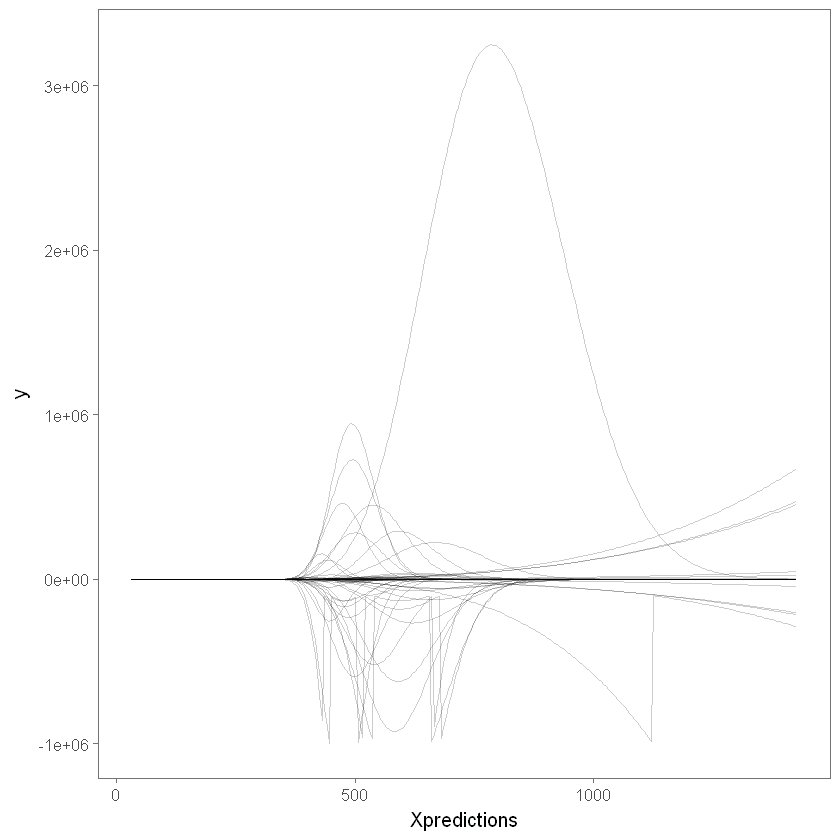

In [229]:
aux_prior_predictions %>%
    filter(!is.na(y)) %>%
    #filter(composition == 'l+r' | composition == 'p+r' | composition == 'l+r+p' | composition == 'l+r*p') %>%
    filter(composition == 'r') %>%
    ggplot() +
    geom_line(aes(x=Xpredictions, y=y, group=group), alpha=0.2) +
    ggthemes::theme_few()